In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.28816519199998
GPU (s):
0.0839482829999838
GPU speedup over CPU: 62x


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rishabh0517/doggieemotion

100% 378M/380M [00:02<00:00, 174MB/s]
100% 380M/380M [00:02<00:00, 145MB/s]


In [ ]:
! unzip doggieemotion.zip

Streaming output truncated to the last 5000 lines.
  inflating: emo/Training/relaxed/3121083725_185fb50243_b.jpg  
  inflating: emo/Training/relaxed/3125507599_328e64a265_b.jpg  
  inflating: emo/Training/relaxed/3138875065_89317e3fab_b.jpg  
  inflating: emo/Training/relaxed/3146044512_ea09600f2d_b.jpg  
  inflating: emo/Training/relaxed/3148409080_56b3631c8c_b.jpg  
  inflating: emo/Training/relaxed/3152697474_6a7518d79d_b.jpg  
  inflating: emo/Training/relaxed/3154132037_5751b39724_b.jpg  
  inflating: emo/Training/relaxed/3154363770_11e5e299a9_b.jpg  
  inflating: emo/Training/relaxed/3155698872_f7baabfa54_b.jpg  
  inflating: emo/Training/relaxed/3156207202_b145e92af0_b.jpg  
  inflating: emo/Training/relaxed/316881402_2992f2fdf2_b.jpg  
  inflating: emo/Training/relaxed/3175048745_b65b4d6d84_b.jpg  
  inflating: emo/Training/relaxed/3177531986_792a04ea78_b.jpg  
  inflating: emo/Training/relaxed/3183678491_c40ef02793_b.jpg  
  inflating: emo/Training/relaxed/3185920705_22bc9b92a

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Flatten,Dense,MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
!unrar x "/content/emo.rar" "/content/IMAGES"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Unexpected end of archive

Extracting from /content/emo.rar

Unexpected end of archive
No files to extract


In [ ]:
labels = ['angry','happy','relaxed','sad']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/emo/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/emo/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1360/1360 [00:02<00:00, 511.12it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.3,random_state=101)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.MaxPooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.25)(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
314/314 [==============================] - ETA: 0s - loss: 1.2832 - accuracy: 0.4453
Epoch 1: val_accuracy improved from -inf to 0.48969, saving model to effnet


314/314 [==============================] - 101s 287ms/step - loss: 1.2832 - accuracy: 0.4453 - val_loss: 1.2255 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 2/30
314/314 [==============================] - ETA: 0s - loss: 1.1718 - accuracy: 0.5087
Epoch 2: val_accuracy improved from 0.48969 to 0.50224, saving model to effnet


314/314 [==============================] - 85s 271ms/step - loss: 1.1718 - accuracy: 0.5087 - val_loss: 1.1782 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 3/30
314/314 [==============================] - ETA: 0s - loss: 1.1123 - accuracy: 0.5445
Epoch 3: val_accuracy improved from 0.50224 to 0.52377, saving model to effnet


314/314 [==============================] - 86s 273ms/step - loss: 1.1123 - accuracy: 0.5445 - val_loss: 1.1537 - val_accuracy: 0.5238 - lr: 0.0010
Epoch 4/30
314/314 [==============================] - ETA: 0s - loss: 1.0590 - accuracy: 0.5699
Epoch 4: val_accuracy did not improve from 0.52377
314/314 [==============================] - 50s 158ms/step - loss: 1.0590 - accuracy: 0.5699 - val_loss: 1.2474 - val_accuracy: 0.4870 - lr: 0.0010
Epoch 5/30
314/314 [==============================] - ETA: 0s - loss: 0.9892 - accuracy: 0.6089
Epoch 5: val_accuracy did not improve from 0.52377

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
314/314 [==============================] - 51s 161ms/step - loss: 0.9892 - accuracy: 0.6089 - val_loss: 1.3060 - val_accuracy: 0.5058 - lr: 0.0010
Epoch 6/30
314/314 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.7152
Epoch 6: val_accuracy did not improve from 0.52377
314/314 [==============================] 

314/314 [==============================] - 86s 275ms/step - loss: 0.5520 - accuracy: 0.7937 - val_loss: 1.5538 - val_accuracy: 0.5372 - lr: 3.0000e-04
Epoch 8/30
314/314 [==============================] - ETA: 0s - loss: 0.4178 - accuracy: 0.8520
Epoch 8: val_accuracy did not improve from 0.53722
314/314 [==============================] - 50s 160ms/step - loss: 0.4178 - accuracy: 0.8520 - val_loss: 1.7141 - val_accuracy: 0.5103 - lr: 3.0000e-04
Epoch 9/30
314/314 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8916
Epoch 9: val_accuracy did not improve from 0.53722

Epoch 9: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
314/314 [==============================] - 51s 164ms/step - loss: 0.3204 - accuracy: 0.8916 - val_loss: 2.0598 - val_accuracy: 0.4942 - lr: 3.0000e-04
Epoch 10/30
314/314 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9365
Epoch 10: val_accuracy did not improve from 0.53722
314/314 [==================

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,pred))

150/150 [==============================] - 7s 36ms/step
              precision    recall  f1-score   support

           0       0.37      0.32      0.34       711
           1       0.61      0.59      0.60      1453
           2       0.46      0.49      0.48      1299
           3       0.54      0.57      0.56      1314

    accuracy                           0.52      4777
   macro avg       0.50      0.49      0.49      4777
weighted avg       0.52      0.52      0.52      4777



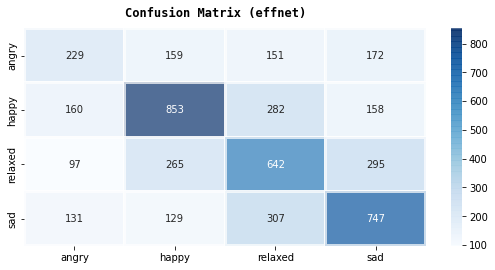

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(9,4))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap='Blues',alpha=0.7,linewidths=2,fmt='g')
fig.text(s='Confusion Matrix (effnet)',size=12,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print(loss, accuracy)

150/150 [==============================] - 5s 35ms/step - loss: 2.5730 - accuracy: 0.5173
2.5729758739471436 0.5172702670097351


In [ ]:
resnet_model = Sequential()
pretrained_model=ResNet50(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
for layer in pretrained_model.layers:
        layer.trainable=False
resnet_model.add(pretrained_model)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model1 = resnet_model.output
model1 = tf.keras.layers.Dense(64,activation='relu')(model1)
model1 = tf.keras.layers.MaxPooling2D()(model1)
model1 = tf.keras.layers.Dropout(rate=0.25)(model1)
model1 = tf.keras.layers.Dense(64,activation='relu')(model1)
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(rate=0.5)(model1)
model1 = tf.keras.layers.Dense(4,activation='softmax')(model1)
model1 = tf.keras.models.Model(inputs=resnet_model.input, outputs = model1)

In [ ]:
tensorboard1 = TensorBoard(log_dir = 'logs1')
checkpoint1 = ModelCheckpoint("resnet",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr1 = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history1 = model1.fit(X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[tensorboard1,checkpoint1,reduce_lr1])

Epoch 1/30
314/314 [==============================] - ETA: 0s - loss: 1.3830 - accuracy: 0.3808
Epoch 1: val_accuracy improved from -inf to 0.45919, saving model to resnet


314/314 [==============================] - 46s 133ms/step - loss: 1.3830 - accuracy: 0.3808 - val_loss: 1.2378 - val_accuracy: 0.4592 - lr: 0.0010
Epoch 2/30
313/314 [============================>.] - ETA: 0s - loss: 1.2160 - accuracy: 0.4747
Epoch 2: val_accuracy improved from 0.45919 to 0.47444, saving model to resnet


314/314 [==============================] - 41s 130ms/step - loss: 1.2161 - accuracy: 0.4745 - val_loss: 1.2143 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 3/30
313/314 [============================>.] - ETA: 0s - loss: 1.1747 - accuracy: 0.4960
Epoch 3: val_accuracy improved from 0.47444 to 0.48969, saving model to resnet


314/314 [==============================] - 40s 128ms/step - loss: 1.1747 - accuracy: 0.4958 - val_loss: 1.1985 - val_accuracy: 0.4897 - lr: 0.0010
Epoch 4/30
313/314 [============================>.] - ETA: 0s - loss: 1.1294 - accuracy: 0.5179
Epoch 4: val_accuracy did not improve from 0.48969
314/314 [==============================] - 19s 62ms/step - loss: 1.1295 - accuracy: 0.5180 - val_loss: 1.1985 - val_accuracy: 0.4825 - lr: 0.0010
Epoch 5/30
313/314 [============================>.] - ETA: 0s - loss: 1.0895 - accuracy: 0.5409
Epoch 5: val_accuracy did not improve from 0.48969

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
314/314 [==============================] - 20s 65ms/step - loss: 1.0893 - accuracy: 0.5409 - val_loss: 1.1937 - val_accuracy: 0.4843 - lr: 0.0010
Epoch 6/30
313/314 [============================>.] - ETA: 0s - loss: 0.9982 - accuracy: 0.5887
Epoch 6: val_accuracy improved from 0.48969 to 0.49327, saving model to resnet


314/314 [==============================] - 41s 129ms/step - loss: 0.9979 - accuracy: 0.5887 - val_loss: 1.2004 - val_accuracy: 0.4933 - lr: 3.0000e-04
Epoch 7/30
313/314 [============================>.] - ETA: 0s - loss: 0.9502 - accuracy: 0.6150
Epoch 7: val_accuracy did not improve from 0.49327
314/314 [==============================] - 20s 63ms/step - loss: 0.9502 - accuracy: 0.6151 - val_loss: 1.2054 - val_accuracy: 0.4843 - lr: 3.0000e-04
Epoch 8/30
313/314 [============================>.] - ETA: 0s - loss: 0.9132 - accuracy: 0.6313
Epoch 8: val_accuracy did not improve from 0.49327

Epoch 8: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
314/314 [==============================] - 20s 64ms/step - loss: 0.9132 - accuracy: 0.6314 - val_loss: 1.2158 - val_accuracy: 0.4906 - lr: 3.0000e-04
Epoch 9/30
313/314 [============================>.] - ETA: 0s - loss: 0.8495 - accuracy: 0.6622
Epoch 9: val_accuracy did not improve from 0.49327
314/314 [======================

314/314 [==============================] - 42s 133ms/step - loss: 0.8014 - accuracy: 0.6775 - val_loss: 1.2498 - val_accuracy: 0.4969 - lr: 2.7000e-05
Epoch 12/30
313/314 [============================>.] - ETA: 0s - loss: 0.7909 - accuracy: 0.6882
Epoch 12: val_accuracy did not improve from 0.49686
314/314 [==============================] - 20s 64ms/step - loss: 0.7906 - accuracy: 0.6884 - val_loss: 1.2580 - val_accuracy: 0.4933 - lr: 2.7000e-05
Epoch 13/30
313/314 [============================>.] - ETA: 0s - loss: 0.7881 - accuracy: 0.6900
Epoch 13: val_accuracy did not improve from 0.49686

Epoch 13: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
314/314 [==============================] - 20s 62ms/step - loss: 0.7880 - accuracy: 0.6901 - val_loss: 1.2621 - val_accuracy: 0.4951 - lr: 2.7000e-05
Epoch 14/30
313/314 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.6896
Epoch 14: val_accuracy did not improve from 0.49686
314/314 [===============

In [ ]:
Effnetb7=EfficientNetB7(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
model5 = Effnetb7.output
model5 = tf.keras.layers.Dense(64,activation='relu')(model5)
model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
model5 = tf.keras.layers.Dropout(rate=0.5)(model5)
model5 = tf.keras.layers.Dense(4,activation='softmax')(model5)
model5 = tf.keras.models.Model(inputs=Effnetb7.input, outputs = model5)

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
model5.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history5= model5.fit(X_train,y_train,validation_split=0.1, epochs =10)

Epoch 1/10
314/314 [==============================] - 331s 941ms/step - loss: 1.2949 - accuracy: 0.4297 - val_loss: 1.4565 - val_accuracy: 0.4143
Epoch 2/10
314/314 [==============================] - 286s 912ms/step - loss: 1.2073 - accuracy: 0.4879 - val_loss: 1.2282 - val_accuracy: 0.4798
Epoch 3/10
314/314 [==============================] - 287s 913ms/step - loss: 1.1499 - accuracy: 0.5150 - val_loss: 1.2547 - val_accuracy: 0.4475
Epoch 4/10
314/314 [==============================] - 291s 926ms/step - loss: 1.1196 - accuracy: 0.5295 - val_loss: 1.2019 - val_accuracy: 0.4897
Epoch 5/10
314/314 [==============================] - 287s 914ms/step - loss: 1.0714 - accuracy: 0.5540 - val_loss: 1.3413 - val_accuracy: 0.4117
Epoch 6/10
314/314 [==============================] - 287s 913ms/step - loss: 1.0169 - accuracy: 0.5831 - val_loss: 1.3012 - val_accuracy: 0.4906
Epoch 7/10
314/314 [==============================] - 286s 912ms/step - loss: 0.9235 - accuracy: 0.6260 - val_loss: 1.3075 -